In [1]:
# Imports
import os
import requests
import pandas as pd
import panel as pn
import panel.widgets as pnw
pn.extension('plotly')
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv
import yfinance as yf
import numpy as np
from itertools import product
from functools import reduce

# Filter warnings for efficiency
# import warnings
# warnings.filterwarnings('ignore')

# Sentiment Analysis Imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient

# Natural Language Processing
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud

# Named Entity Recognition
import spacy
from spacy import displacy

# Load .env enviroment variables
load_dotenv()

%matplotlib inline

# NEWSAPI SENTIMENT ANALYSIS

## Sentiment Score

In [2]:
# NewsAPI Key
newsapi = NewsApiClient(api_key=os.environ["NEWS_API_KEY"])

# Fetch the Bitcoin news articles
btc_headlines = newsapi.get_everything(
    q="bitcoin",
    language="en",
    sort_by="relevancy",
    #sources="business-insider, techcrunch, reuters",
    domains="cnbc.com, yahoo.com, coindesk.com"
)

btc_headlines["totalResults"]

813

In [3]:
# Fetch the ethereum news articles
eth_headlines = newsapi.get_everything(
    q="ethereum",
    language="en",
    sort_by="relevancy",
    #sources="business-insider, techcrunch, reuters",
    domains="cnbc.com, yahoo.com, coindesk.com"
)

eth_headlines["totalResults"]

368

In [4]:
# Fetch the S&P 500 news articles
sp_headlines = newsapi.get_everything(
    q="S&P 500 OR SPY",
    language="en",
    sort_by="relevancy",
    #sources="business-insider, techcrunch, reuters",
    domains="cnbc.com, bloomberg.com"
)

sp_headlines["totalResults"]

343

In [5]:
# Fetch the NASDAQ news articles
qqq_headlines = newsapi.get_everything(
    q="Nasdaq 100 OR QQQ",
    language="en",
    sort_by="relevancy",
    #sources="business-insider, techcrunch, reuters",
    domains="cnbc.com, bloomberg.com"
)

qqq_headlines["totalResults"]

193

In [6]:
# Create the Bitcoin sentiment scores DataFrame
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]
            url = article["url"]
            source = article["source"]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language,
                "url": url,
                "source": source
                
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

# Create the Bitcoin sentiment scores DataFrame
btc_news = create_df(btc_headlines["articles"], "en")
btc_news.head()

date                                        description language  \
0  2021-08-16  Dow futures fell more than 110 points to start...       en   
1  2021-08-16  Crypto Market Retakes $2 Trillion Market Cap A...       en   
2  2021-08-09  It was an especially volatile day for bitcoin,...       en   
3  2021-08-18  Bitcoin and other cryptocurrencies are consoli...       en   
4  2021-08-20  Bitcoin rallied after Coinbase announced it wi...       en   

                                        source  \
0                 {'id': None, 'name': 'CNBC'}   
1  {'id': None, 'name': 'Yahoo Entertainment'}   
2  {'id': None, 'name': 'Yahoo Entertainment'}   
3  {'id': None, 'name': 'Yahoo Entertainment'}   
4  {'id': None, 'name': 'Yahoo Entertainment'}   

                                                text  \
0  Dow futures fell more than 110 points to start...   
1  (Bloomberg) -- The total market value of crypt...   
2  It was a volatile day for bitcoin, as its near...   
3  Bitcoin is roughly flat over the past 24 hours...   
4  Cryptocurrencies are ending the week on a stro...   

                                               title  \
0  What to watch today: Markets look lower on con...   
1  Crypto Market Retakes $2 Trillion Market Cap A...   
2  Bitcoin Buyers Face Stiff Resistance At 200-da...   
3  Market Wrap: Bitcoin Trades Sideways as Instit...   
4  Market Wrap: Bitcoin Rallies Ahead of $50K Res...   

                                                 url  
0  https://www.cnbc.com/2021/08/16/what-to-watch-...  
1  https://finance.yahoo.com/news/crypto-market-r...  
2  https://finance.yahoo.com/news/bitcoin-buyers-...  
3  https://finance.yahoo.com/news/market-wrap-bit...  
4  https://finance.yahoo.com/news/market-wrap-bit...

In [7]:
# Create the Ethereum sentiment scores DataFrame
eth_news = create_df(eth_headlines["articles"], "en")
eth_news.head()

date                                        description language  \
0  2021-08-12  Major mining machine makers like Bitmain are b...       en   
1  2021-08-23  Shares of crypto-related stocks, including Mar...       en   
2  2021-08-05  "The notion of ethereum becoming a deflationar...       en   
3  2021-08-13  The largest cryptocurrency by market value was...       en   
4  2021-09-01  Shares of crypto-related stocks, including Mar...       en   

                                        source  \
0  {'id': None, 'name': 'Yahoo Entertainment'}   
1  {'id': None, 'name': 'Yahoo Entertainment'}   
2  {'id': None, 'name': 'Yahoo Entertainment'}   
3  {'id': None, 'name': 'Yahoo Entertainment'}   
4  {'id': None, 'name': 'Yahoo Entertainment'}   

                                                text  \
0  Major bitcoin mining firms and miner manufactu...   
1  Shares of crypto-related stocks, including Mar...   
2  Ether prices rose in digital-asset markets on ...   
3  Bitcoin’s price rose Friday, back above $46,00...   
4  Shares of crypto-related stocks, including Mar...   

                                               title  \
0  Ethereum Miners Make Multimillion-Dollar Bet o...   
1  Why Bitcoin-Related And Ethereum-Related Stock...   
2  What Crypto Analysts Are Saying About the Ethe...   
3  Market Wrap: Ethereum Keeps Burning and Price ...   
4  Why Bitcoin-Related And Ethereum-Related Stock...   

                                                 url  
0  https://finance.yahoo.com/news/ethereum-miners...  
1  https://finance.yahoo.com/news/why-bitcoin-rel...  
2  https://finance.yahoo.com/news/crypto-analysts...  
3  https://finance.yahoo.com/news/market-wrap-eth...  
4  https://finance.yahoo.com/news/why-bitcoin-rel...

In [8]:
# Create the S&P 500 sentiment scores DataFrame
sp_news = create_df(sp_headlines["articles"], "en")
sp_news.head()

date                                        description language  \
0  2021-08-13  The S&P 500, which has already notched 44 reco...       en   
1  2021-08-16  Women hold at least 30% of seats on a majority...       en   
2  2021-08-17  The appointment of former Hanesbrands Inc. gen...       en   
3  2021-08-14  Ten-year Treasury yields are mired below 1.3%....       en   
4  2021-09-01  It’s still too early to get bearish on the mar...       en   

                                     source  \
0  {'id': 'bloomberg', 'name': 'Bloomberg'}   
1  {'id': 'bloomberg', 'name': 'Bloomberg'}   
2  {'id': 'bloomberg', 'name': 'Bloomberg'}   
3  {'id': 'bloomberg', 'name': 'Bloomberg'}   
4  {'id': 'bloomberg', 'name': 'Bloomberg'}   

                                                text  \
0                Where To Watch\r\nFind us on social   
1  Women hold at least 30% of seats on a majority...   
2  The appointment of former \r\nHanesbrands Inc....   
3  Ten-year Treasury yields are mired below 1.3%....   
4  Its still too early to get bearish on the mark...   

                                               title  \
0   Big Bull: Golub Sees S&P Hitting 5,000 Next Year   
1  Women's Gains Push Majority of S&P 500 Boards ...   
2  Women Gain on S&P 500 Bank Boards as Regions A...   
3  S&P 500 Snubbing Dire View in Bonds Has Earnin...   
4  Federated's Linda Duessel Says It's Still Too ...   

                                                 url  
0  https://www.bloomberg.com/news/videos/2021-08-...  
1  https://www.bloomberg.com/news/articles/2021-0...  
2  https://www.bloomberg.com/news/articles/2021-0...  
3  https://www.bloomberg.com/news/articles/2021-0...  
4  https://www.bloomberg.com/news/articles/2021-0...

In [9]:
# Create the Nasdaq 100 sentiment scores DataFrame
qqq_news = create_df(qqq_headlines["articles"], "en")
qqq_news.head()

date                                        description language  \
0  2021-08-13  From faraway Kazakhstan, an obscure brokerage ...       en   
1  2021-08-12  Nu Pagamentos SA, the Brazilian fintech backed...       en   
2  2021-08-30  Krispy Kreme Inc. the maker of Original Glazed...       en   
3  2021-08-22                                                          en   
4  2021-08-30  Adtran Inc. of the U.S. offered to buy German ...       en   

                                     source  \
0  {'id': 'bloomberg', 'name': 'Bloomberg'}   
1  {'id': 'bloomberg', 'name': 'Bloomberg'}   
2  {'id': 'bloomberg', 'name': 'Bloomberg'}   
3  {'id': 'bloomberg', 'name': 'Bloomberg'}   
4  {'id': 'bloomberg', 'name': 'Bloomberg'}   

                                                text  \
0  Six thousand miles from Wall Street, in the an...   
1  Nu Pagamentos SA, the Brazilian fintech backed...   
2  Krispy Kreme Inc. the maker of Original Glazed...   
3  Chinas stock exchanges have issued revised dra...   
4  From the Apple scoop machineBe the first to kn...   

                                               title  \
0  Mystery Hedge Fund Bolsters 500% Return on Cur...   
1  Buffett-Backed Nubank Is Said to Plan $2 Billi...   
2  Krispy Kreme Opens Egypt Store to Accelerate G...   
3  China Exchanges to Improve IPO Pricing on Star...   
4  Adtran Makes Takeover Bid for Germany's ADVA A...   

                                                 url  
0  https://www.bloomberg.com/news/articles/2021-0...  
1  https://www.bloomberg.com/news/articles/2021-0...  
2  https://www.bloomberg.com/news/articles/2021-0...  
3  https://www.bloomberg.com/news/articles/2021-0...  
4  https://www.bloomberg.com/news/articles/2021-0...

In [10]:
# Create the Bitcoin sentiment scores DataFrame
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0
    if score >= 0.05:
        result = 1
    elif score <= -0.05:
        result = -1
    return result

# Sentiment scores dictionaries
def sent_score(df):
    title_sent = {
        "title_compound": [],
        "title_pos": [],
        "title_neu": [],
        "title_neg": [],
        "title_sent": [],
    }
    text_sent = {
        "text_compound": [],
        "text_pos": [],
        "text_neu": [],
        "text_neg": [],
        "text_sent": [],
    }

# Get sentiment for the text and the title
    for index, row in df.iterrows():
        try:
            # Sentiment scoring with VADER
            title_sentiment = analyzer.polarity_scores(row["title"])
            title_sent["title_compound"].append(title_sentiment["compound"])
            title_sent["title_pos"].append(title_sentiment["pos"])
            title_sent["title_neu"].append(title_sentiment["neu"])
            title_sent["title_neg"].append(title_sentiment["neg"])
            title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))
            text_sentiment = analyzer.polarity_scores(row["text"])
            text_sent["text_compound"].append(text_sentiment["compound"])
            text_sent["text_pos"].append(text_sentiment["pos"])
            text_sent["text_neu"].append(text_sentiment["neu"])
            text_sent["text_neg"].append(text_sentiment["neg"])
            text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
        except AttributeError:
            pass
    title_sentiment_df = pd.DataFrame(title_sent)
    text_sentiment_df = pd.DataFrame(text_sent)
    df = df.join(title_sentiment_df).join(text_sentiment_df)
    return df

In [11]:
btc_news_sent = sent_score(btc_news)
btc_news_sent.head()

date                                        description language  \
0  2021-08-16  Dow futures fell more than 110 points to start...       en   
1  2021-08-16  Crypto Market Retakes $2 Trillion Market Cap A...       en   
2  2021-08-09  It was an especially volatile day for bitcoin,...       en   
3  2021-08-18  Bitcoin and other cryptocurrencies are consoli...       en   
4  2021-08-20  Bitcoin rallied after Coinbase announced it wi...       en   

                                        source  \
0                 {'id': None, 'name': 'CNBC'}   
1  {'id': None, 'name': 'Yahoo Entertainment'}   
2  {'id': None, 'name': 'Yahoo Entertainment'}   
3  {'id': None, 'name': 'Yahoo Entertainment'}   
4  {'id': None, 'name': 'Yahoo Entertainment'}   

                                                text  \
0  Dow futures fell more than 110 points to start...   
1  (Bloomberg) -- The total market value of crypt...   
2  It was a volatile day for bitcoin, as its near...   
3  Bitcoin is roughly flat over the past 24 hours...   
4  Cryptocurrencies are ending the week on a stro...   

                                               title  \
0  What to watch today: Markets look lower on con...   
1  Crypto Market Retakes $2 Trillion Market Cap A...   
2  Bitcoin Buyers Face Stiff Resistance At 200-da...   
3  Market Wrap: Bitcoin Trades Sideways as Instit...   
4  Market Wrap: Bitcoin Rallies Ahead of $50K Res...   

                                                 url  title_compound  \
0  https://www.cnbc.com/2021/08/16/what-to-watch-...          0.1027   
1  https://finance.yahoo.com/news/crypto-market-r...          0.0000   
2  https://finance.yahoo.com/news/bitcoin-buyers-...          0.0000   
3  https://finance.yahoo.com/news/market-wrap-bit...         -0.1280   
4  https://finance.yahoo.com/news/market-wrap-bit...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0      0.138      0.745      0.117           1        -0.0516     0.064   
1      0.000      1.000      0.000           0         0.8074     0.237   
2      0.000      1.000      0.000           0         0.0000     0.000   
3      0.000      0.870      0.130          -1         0.0000     0.000   
4      0.000      1.000      0.000           0         0.1280     0.080   

   text_neu  text_neg  text_sent  
0     0.866     0.069         -1  
1     0.763     0.000          1  
2     1.000     0.000          0  
3     1.000     0.000          0  
4     0.852     0.068          1

In [12]:
eth_news_sent = sent_score(eth_news)
eth_news_sent.head()

date                                        description language  \
0  2021-08-12  Major mining machine makers like Bitmain are b...       en   
1  2021-08-23  Shares of crypto-related stocks, including Mar...       en   
2  2021-08-05  "The notion of ethereum becoming a deflationar...       en   
3  2021-08-13  The largest cryptocurrency by market value was...       en   
4  2021-09-01  Shares of crypto-related stocks, including Mar...       en   

                                        source  \
0  {'id': None, 'name': 'Yahoo Entertainment'}   
1  {'id': None, 'name': 'Yahoo Entertainment'}   
2  {'id': None, 'name': 'Yahoo Entertainment'}   
3  {'id': None, 'name': 'Yahoo Entertainment'}   
4  {'id': None, 'name': 'Yahoo Entertainment'}   

                                                text  \
0  Major bitcoin mining firms and miner manufactu...   
1  Shares of crypto-related stocks, including Mar...   
2  Ether prices rose in digital-asset markets on ...   
3  Bitcoin’s price rose Friday, back above $46,00...   
4  Shares of crypto-related stocks, including Mar...   

                                               title  \
0  Ethereum Miners Make Multimillion-Dollar Bet o...   
1  Why Bitcoin-Related And Ethereum-Related Stock...   
2  What Crypto Analysts Are Saying About the Ethe...   
3  Market Wrap: Ethereum Keeps Burning and Price ...   
4  Why Bitcoin-Related And Ethereum-Related Stock...   

                                                 url  title_compound  \
0  https://finance.yahoo.com/news/ethereum-miners...         -0.3182   
1  https://finance.yahoo.com/news/why-bitcoin-rel...          0.0000   
2  https://finance.yahoo.com/news/crypto-analysts...         -0.1027   
3  https://finance.yahoo.com/news/market-wrap-eth...          0.0000   
4  https://finance.yahoo.com/news/why-bitcoin-rel...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0        0.0      0.753      0.247          -1         0.0000     0.000   
1        0.0      1.000      0.000           0        -0.0258     0.128   
2        0.0      0.865      0.135          -1        -0.1027     0.000   
3        0.0      1.000      0.000           0         0.0772     0.062   
4        0.0      1.000      0.000           0        -0.0258     0.128   

   text_neu  text_neg  text_sent  
0     1.000     0.000          0  
1     0.769     0.103          0  
2     0.958     0.042         -1  
3     0.883     0.055          1  
4     0.769     0.103          0

In [13]:
sp_news_sent = sent_score(sp_news)
sp_news_sent.head()

date                                        description language  \
0  2021-08-13  The S&P 500, which has already notched 44 reco...       en   
1  2021-08-16  Women hold at least 30% of seats on a majority...       en   
2  2021-08-17  The appointment of former Hanesbrands Inc. gen...       en   
3  2021-08-14  Ten-year Treasury yields are mired below 1.3%....       en   
4  2021-09-01  It’s still too early to get bearish on the mar...       en   

                                     source  \
0  {'id': 'bloomberg', 'name': 'Bloomberg'}   
1  {'id': 'bloomberg', 'name': 'Bloomberg'}   
2  {'id': 'bloomberg', 'name': 'Bloomberg'}   
3  {'id': 'bloomberg', 'name': 'Bloomberg'}   
4  {'id': 'bloomberg', 'name': 'Bloomberg'}   

                                                text  \
0                Where To Watch\r\nFind us on social   
1  Women hold at least 30% of seats on a majority...   
2  The appointment of former \r\nHanesbrands Inc....   
3  Ten-year Treasury yields are mired below 1.3%....   
4  Its still too early to get bearish on the mark...   

                                               title  \
0   Big Bull: Golub Sees S&P Hitting 5,000 Next Year   
1  Women's Gains Push Majority of S&P 500 Boards ...   
2  Women Gain on S&P 500 Bank Boards as Regions A...   
3  S&P 500 Snubbing Dire View in Bonds Has Earnin...   
4  Federated's Linda Duessel Says It's Still Too ...   

                                                 url  title_compound  \
0  https://www.bloomberg.com/news/videos/2021-08-...          0.0000   
1  https://www.bloomberg.com/news/articles/2021-0...          0.3400   
2  https://www.bloomberg.com/news/articles/2021-0...          0.5267   
3  https://www.bloomberg.com/news/articles/2021-0...         -0.5994   
4  https://www.bloomberg.com/news/articles/2021-0...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0      0.000      1.000      0.000           0         0.0000     0.000   
1      0.179      0.821      0.000           1         0.0772     0.035   
2      0.236      0.764      0.000           1         0.2960     0.066   
3      0.000      0.671      0.329          -1         0.5267     0.132   
4      0.000      1.000      0.000           0         0.5267     0.089   

   text_neu  text_neg  text_sent  
0     1.000       0.0          0  
1     0.965       0.0          1  
2     0.934       0.0          1  
3     0.868       0.0          1  
4     0.911       0.0          1

In [14]:
qqq_news_sent = sent_score(qqq_news)
qqq_news_sent.head()

date                                        description language  \
0  2021-08-13  From faraway Kazakhstan, an obscure brokerage ...       en   
1  2021-08-12  Nu Pagamentos SA, the Brazilian fintech backed...       en   
2  2021-08-30  Krispy Kreme Inc. the maker of Original Glazed...       en   
3  2021-08-22                                                          en   
4  2021-08-30  Adtran Inc. of the U.S. offered to buy German ...       en   

                                     source  \
0  {'id': 'bloomberg', 'name': 'Bloomberg'}   
1  {'id': 'bloomberg', 'name': 'Bloomberg'}   
2  {'id': 'bloomberg', 'name': 'Bloomberg'}   
3  {'id': 'bloomberg', 'name': 'Bloomberg'}   
4  {'id': 'bloomberg', 'name': 'Bloomberg'}   

                                                text  \
0  Six thousand miles from Wall Street, in the an...   
1  Nu Pagamentos SA, the Brazilian fintech backed...   
2  Krispy Kreme Inc. the maker of Original Glazed...   
3  Chinas stock exchanges have issued revised dra...   
4  From the Apple scoop machineBe the first to kn...   

                                               title  \
0  Mystery Hedge Fund Bolsters 500% Return on Cur...   
1  Buffett-Backed Nubank Is Said to Plan $2 Billi...   
2  Krispy Kreme Opens Egypt Store to Accelerate G...   
3  China Exchanges to Improve IPO Pricing on Star...   
4  Adtran Makes Takeover Bid for Germany's ADVA A...   

                                                 url  title_compound  \
0  https://www.bloomberg.com/news/articles/2021-0...          0.3182   
1  https://www.bloomberg.com/news/articles/2021-0...          0.0000   
2  https://www.bloomberg.com/news/articles/2021-0...          0.0000   
3  https://www.bloomberg.com/news/articles/2021-0...          0.4404   
4  https://www.bloomberg.com/news/articles/2021-0...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0      0.204      0.796        0.0           1        -0.4215     0.000   
1      0.000      1.000        0.0           0         0.0258     0.031   
2      0.000      1.000        0.0           0         0.3182     0.065   
3      0.244      0.756        0.0           1         0.6249     0.155   
4      0.000      1.000        0.0           0         0.1531     0.045   

   text_neu  text_neg  text_sent  
0     0.920     0.080         -1  
1     0.969     0.000          0  
2     0.935     0.000          1  
3     0.803     0.042          1  
4     0.955     0.000          1

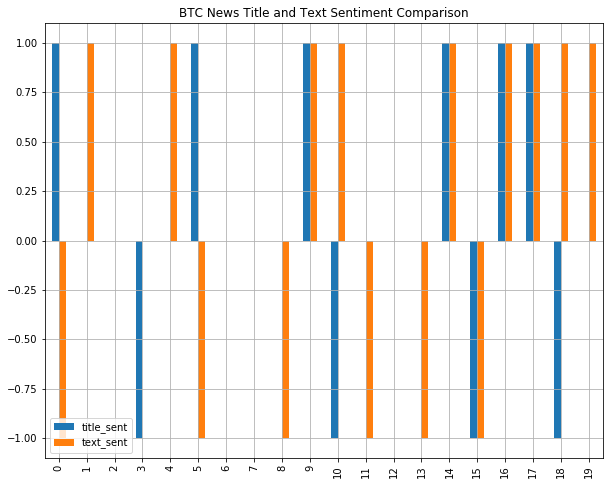

In [15]:
# Plot bar chart
btc_news_sent.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="BTC News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [16]:
# Describe dataframe
btc_news_sent.describe()

title_compound  title_pos  title_neu  title_neg  title_sent  \
count       20.000000  20.000000  20.000000  20.000000   20.000000   
mean         0.064095   0.075700   0.876200   0.048100    0.100000   
std          0.317508   0.130367   0.148633   0.105177    0.718185   
min         -0.557400   0.000000   0.549000   0.000000   -1.000000   
25%          0.000000   0.000000   0.776500   0.000000    0.000000   
50%          0.000000   0.000000   0.954500   0.000000    0.000000   
75%          0.167325   0.157000   1.000000   0.022750    1.000000   
max          0.750600   0.451000   1.000000   0.419000    1.000000   

       text_compound   text_pos   text_neu   text_neg  text_sent  
count      20.000000  20.000000  20.000000  20.000000  20.000000  
mean        0.139165   0.061050   0.913650   0.025250   0.150000  
std         0.407843   0.076971   0.071075   0.036468   0.875094  
min        -0.557400   0.000000   0.763000   0.000000  -1.000000  
25%        -0.089275   0.000000   0.862500   0.000000  -1.000000  
50%         0.000000   0.026500   0.920500   0.000000   0.000000  
75%         0.462375   0.083500   0.961000   0.065500   1.000000  
max         0.807400   0.237000   1.000000   0.104000   1.000000

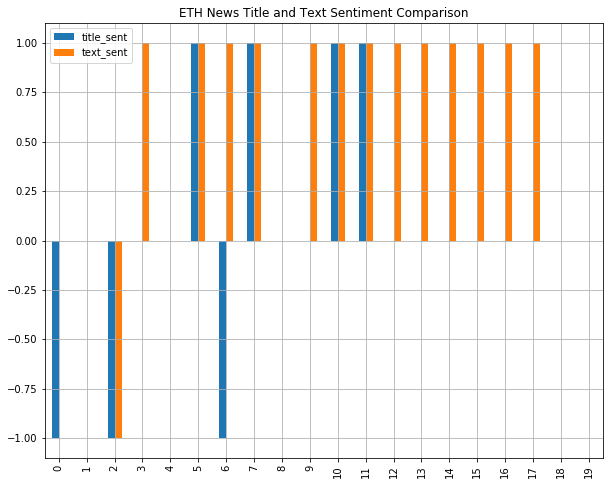

In [17]:
# Plot bar chart
eth_news_sent.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="ETH News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [18]:
# Describe dataframe
eth_news_sent.describe()

title_compound  title_pos  title_neu  title_neg  title_sent  \
count       20.000000  20.000000  20.000000  20.000000   20.000000   
mean         0.027290   0.051000   0.910700   0.038300    0.050000   
std          0.218816   0.107183   0.132693   0.081173    0.604805   
min         -0.476700   0.000000   0.625000   0.000000   -1.000000   
25%          0.000000   0.000000   0.784500   0.000000    0.000000   
50%          0.000000   0.000000   1.000000   0.000000    0.000000   
75%          0.000000   0.000000   1.000000   0.000000    0.000000   
max          0.470300   0.336000   1.000000   0.247000    1.000000   

       text_compound   text_pos   text_neu   text_neg  text_sent  
count      20.000000  20.000000  20.000000  20.000000  20.000000  
mean        0.313015   0.085800   0.893950   0.020250   0.600000  
std         0.292277   0.063912   0.080626   0.034823   0.598243  
min        -0.102700   0.000000   0.707000   0.000000  -1.000000  
25%         0.000000   0.046500   0.856000   0.000000   0.000000  
50%         0.409400   0.092000   0.905000   0.000000   1.000000  
75%         0.526700   0.115250   0.930250   0.043250   1.000000  
max         0.857300   0.246000   1.000000   0.103000   1.000000

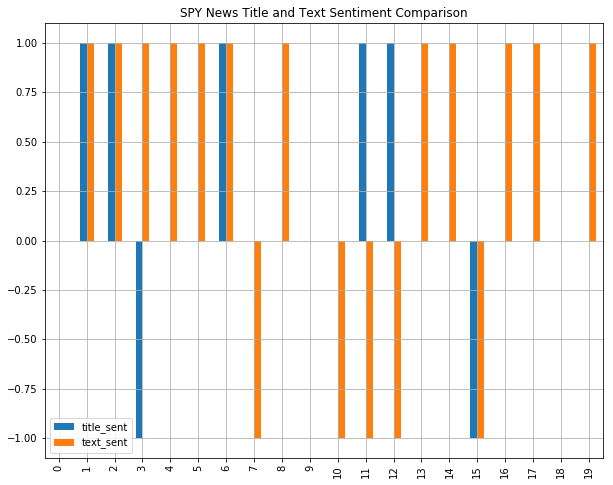

In [19]:
# Plot bar chart
sp_news_sent.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="SPY News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [20]:
# Describe dataframe
sp_news_sent.describe()

title_compound  title_pos  title_neu  title_neg  title_sent  \
count       20.000000  20.000000  20.000000  20.000000   20.000000   
mean         0.045925   0.057900   0.905950   0.036150    0.150000   
std          0.259342   0.108444   0.143303   0.091723    0.587143   
min         -0.599400   0.000000   0.574000   0.000000   -1.000000   
25%          0.000000   0.000000   0.818500   0.000000    0.000000   
50%          0.000000   0.000000   1.000000   0.000000    0.000000   
75%          0.012900   0.041750   1.000000   0.000000    0.250000   
max          0.670500   0.355000   1.000000   0.329000    1.000000   

       text_compound   text_pos   text_neu   text_neg  text_sent  
count      20.000000  20.000000  20.000000  20.000000  20.000000  
mean        0.151820   0.077150   0.881800   0.041000   0.350000  
std         0.435225   0.057716   0.084933   0.067773   0.875094  
min        -0.784500   0.000000   0.700000   0.000000  -1.000000  
25%        -0.074000   0.043250   0.830250   0.000000  -0.250000  
50%         0.273000   0.068000   0.889500   0.000000   1.000000  
75%         0.493475   0.118500   0.935250   0.068000   1.000000  
max         0.805600   0.206000   1.000000   0.236000   1.000000

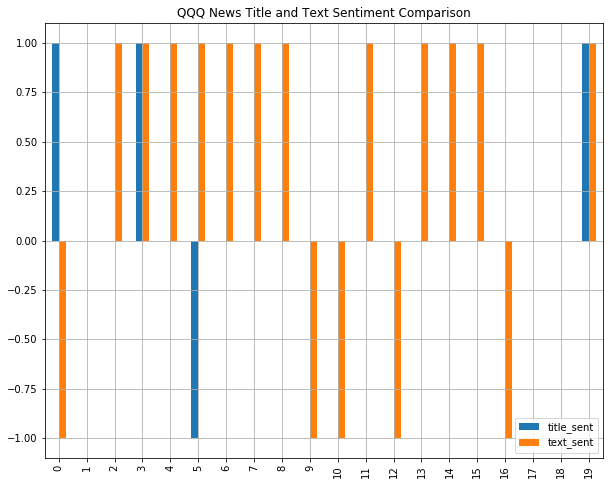

In [21]:
# Plot bar chart
qqq_news_sent.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="QQQ News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [22]:
# Describe dataframe
qqq_news_sent.describe()

title_compound  title_pos  title_neu  title_neg  title_sent  \
count       20.000000  20.000000  20.000000  20.000000   20.000000   
mean         0.032135   0.030050   0.961900   0.008050    0.100000   
std          0.148098   0.074869   0.079951   0.036001    0.447214   
min         -0.318200   0.000000   0.756000   0.000000   -1.000000   
25%          0.000000   0.000000   1.000000   0.000000    0.000000   
50%          0.000000   0.000000   1.000000   0.000000    0.000000   
75%          0.000000   0.000000   1.000000   0.000000    0.000000   
max          0.440400   0.244000   1.000000   0.161000    1.000000   

       text_compound   text_pos  text_neu   text_neg  text_sent  
count      20.000000  20.000000  20.00000  20.000000  20.000000  
mean        0.139060   0.079200   0.87265   0.048150   0.350000  
std         0.490337   0.057219   0.08500   0.075632   0.875094  
min        -0.784500   0.000000   0.70000   0.000000  -1.000000  
25%        -0.056575   0.031750   0.80175   0.000000  -0.250000  
50%         0.344900   0.083000   0.88700   0.000000   1.000000  
75%         0.534375   0.126750   0.92900   0.071000   1.000000  
max         0.718400   0.189000   1.00000   0.236000   1.000000

In [23]:
# Instantiate the lemmatizer
wnl = WordNetLemmatizer() 

# Create a list of stopwords
stop = stopwords.words('english')

# Expand the default stopwords list if necessary
stop.append("u")
stop.append("it'")
stop.append("'s")
stop.append("n't")
stop.append('…')
stop.append("\`")
stop.append('``')
stop.append('chars')
stop.append('char')
stop.append("''")
stop.append("'")
stop.append("’")
stop.append("S")
stop.append("&")
stop.append("P")
stop.append("500")
stop.append("amp")
stop = set(stop)

# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    # Create a list of the words
    words = word_tokenize(text)
    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    # Remove the punctuation
    words = list(filter(lambda t: t not in punctuation, words))
    # Remove the stopwords
    words = list(filter(lambda t: t.lower() not in stop, words))
    # Lemmatize Words into root words
    tokens = [wnl.lemmatize(word) for word in words]
    return tokens

# Create a new tokens column for Bitcoin
btc_news_sent["tokens"] = btc_news_sent.text.apply(tokenizer)
btc_news_sent.head()

date                                        description language  \
0  2021-08-16  Dow futures fell more than 110 points to start...       en   
1  2021-08-16  Crypto Market Retakes $2 Trillion Market Cap A...       en   
2  2021-08-09  It was an especially volatile day for bitcoin,...       en   
3  2021-08-18  Bitcoin and other cryptocurrencies are consoli...       en   
4  2021-08-20  Bitcoin rallied after Coinbase announced it wi...       en   

                                        source  \
0                 {'id': None, 'name': 'CNBC'}   
1  {'id': None, 'name': 'Yahoo Entertainment'}   
2  {'id': None, 'name': 'Yahoo Entertainment'}   
3  {'id': None, 'name': 'Yahoo Entertainment'}   
4  {'id': None, 'name': 'Yahoo Entertainment'}   

                                                text  \
0  Dow futures fell more than 110 points to start...   
1  (Bloomberg) -- The total market value of crypt...   
2  It was a volatile day for bitcoin, as its near...   
3  Bitcoin is roughly flat over the past 24 hours...   
4  Cryptocurrencies are ending the week on a stro...   

                                               title  \
0  What to watch today: Markets look lower on con...   
1  Crypto Market Retakes $2 Trillion Market Cap A...   
2  Bitcoin Buyers Face Stiff Resistance At 200-da...   
3  Market Wrap: Bitcoin Trades Sideways as Instit...   
4  Market Wrap: Bitcoin Rallies Ahead of $50K Res...   

                                                 url  title_compound  \
0  https://www.cnbc.com/2021/08/16/what-to-watch-...          0.1027   
1  https://finance.yahoo.com/news/crypto-market-r...          0.0000   
2  https://finance.yahoo.com/news/bitcoin-buyers-...          0.0000   
3  https://finance.yahoo.com/news/market-wrap-bit...         -0.1280   
4  https://finance.yahoo.com/news/market-wrap-bit...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0      0.138      0.745      0.117           1        -0.0516     0.064   
1      0.000      1.000      0.000           0         0.8074     0.237   
2      0.000      1.000      0.000           0         0.0000     0.000   
3      0.000      0.870      0.130          -1         0.0000     0.000   
4      0.000      1.000      0.000           0         0.1280     0.080   

   text_neu  text_neg  text_sent  \
0     0.866     0.069         -1   
1     0.763     0.000          1   
2     1.000     0.000          0   
3     1.000     0.000          0   
4     0.852     0.068          1   

                                              tokens  
0  [Dow, future, fell, 110, point, start, week, i...  
1  [Bloomberg, --, total, market, value, cryptocu...  
2  [volatile, day, bitcoin, near-term, price, act...  
3  [Bitcoin, roughly, flat, past, 24, hour, short...  
4  [Cryptocurrencies, ending, week, strong, note,...

In [24]:
# Create a new tokens column for Ethereum
eth_news_sent["tokens"] = eth_news_sent.text.apply(tokenizer)
eth_news_sent.head()

date                                        description language  \
0  2021-08-12  Major mining machine makers like Bitmain are b...       en   
1  2021-08-23  Shares of crypto-related stocks, including Mar...       en   
2  2021-08-05  "The notion of ethereum becoming a deflationar...       en   
3  2021-08-13  The largest cryptocurrency by market value was...       en   
4  2021-09-01  Shares of crypto-related stocks, including Mar...       en   

                                        source  \
0  {'id': None, 'name': 'Yahoo Entertainment'}   
1  {'id': None, 'name': 'Yahoo Entertainment'}   
2  {'id': None, 'name': 'Yahoo Entertainment'}   
3  {'id': None, 'name': 'Yahoo Entertainment'}   
4  {'id': None, 'name': 'Yahoo Entertainment'}   

                                                text  \
0  Major bitcoin mining firms and miner manufactu...   
1  Shares of crypto-related stocks, including Mar...   
2  Ether prices rose in digital-asset markets on ...   
3  Bitcoin’s price rose Friday, back above $46,00...   
4  Shares of crypto-related stocks, including Mar...   

                                               title  \
0  Ethereum Miners Make Multimillion-Dollar Bet o...   
1  Why Bitcoin-Related And Ethereum-Related Stock...   
2  What Crypto Analysts Are Saying About the Ethe...   
3  Market Wrap: Ethereum Keeps Burning and Price ...   
4  Why Bitcoin-Related And Ethereum-Related Stock...   

                                                 url  title_compound  \
0  https://finance.yahoo.com/news/ethereum-miners...         -0.3182   
1  https://finance.yahoo.com/news/why-bitcoin-rel...          0.0000   
2  https://finance.yahoo.com/news/crypto-analysts...         -0.1027   
3  https://finance.yahoo.com/news/market-wrap-eth...          0.0000   
4  https://finance.yahoo.com/news/why-bitcoin-rel...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0        0.0      0.753      0.247          -1         0.0000     0.000   
1        0.0      1.000      0.000           0        -0.0258     0.128   
2        0.0      0.865      0.135          -1        -0.1027     0.000   
3        0.0      1.000      0.000           0         0.0772     0.062   
4        0.0      1.000      0.000           0        -0.0258     0.128   

   text_neu  text_neg  text_sent  \
0     1.000     0.000          0   
1     0.769     0.103          0   
2     0.958     0.042         -1   
3     0.883     0.055          1   
4     0.769     0.103          0   

                                              tokens  
0  [Major, bitcoin, mining, firm, miner, manufact...  
1  [Shares, crypto-related, stock, including, Mar...  
2  [Ether, price, rose, digital-asset, market, Th...  
3  [Bitcoin, price, rose, Friday, back, 46,000, d...  
4  [Shares, crypto-related, stock, including, Mar...

In [25]:
# Create a new tokens column for S&P 500
sp_news_sent["tokens"] = sp_news_sent.text.apply(tokenizer)
sp_news_sent.head()

date                                        description language  \
0  2021-08-13  The S&P 500, which has already notched 44 reco...       en   
1  2021-08-16  Women hold at least 30% of seats on a majority...       en   
2  2021-08-17  The appointment of former Hanesbrands Inc. gen...       en   
3  2021-08-14  Ten-year Treasury yields are mired below 1.3%....       en   
4  2021-09-01  It’s still too early to get bearish on the mar...       en   

                                     source  \
0  {'id': 'bloomberg', 'name': 'Bloomberg'}   
1  {'id': 'bloomberg', 'name': 'Bloomberg'}   
2  {'id': 'bloomberg', 'name': 'Bloomberg'}   
3  {'id': 'bloomberg', 'name': 'Bloomberg'}   
4  {'id': 'bloomberg', 'name': 'Bloomberg'}   

                                                text  \
0                Where To Watch\r\nFind us on social   
1  Women hold at least 30% of seats on a majority...   
2  The appointment of former \r\nHanesbrands Inc....   
3  Ten-year Treasury yields are mired below 1.3%....   
4  Its still too early to get bearish on the mark...   

                                               title  \
0   Big Bull: Golub Sees S&P Hitting 5,000 Next Year   
1  Women's Gains Push Majority of S&P 500 Boards ...   
2  Women Gain on S&P 500 Bank Boards as Regions A...   
3  S&P 500 Snubbing Dire View in Bonds Has Earnin...   
4  Federated's Linda Duessel Says It's Still Too ...   

                                                 url  title_compound  \
0  https://www.bloomberg.com/news/videos/2021-08-...          0.0000   
1  https://www.bloomberg.com/news/articles/2021-0...          0.3400   
2  https://www.bloomberg.com/news/articles/2021-0...          0.5267   
3  https://www.bloomberg.com/news/articles/2021-0...         -0.5994   
4  https://www.bloomberg.com/news/articles/2021-0...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0      0.000      1.000      0.000           0         0.0000     0.000   
1      0.179      0.821      0.000           1         0.0772     0.035   
2      0.236      0.764      0.000           1         0.2960     0.066   
3      0.000      0.671      0.329          -1         0.5267     0.132   
4      0.000      1.000      0.000           0         0.5267     0.089   

   text_neu  text_neg  text_sent  \
0     1.000       0.0          0   
1     0.965       0.0          1   
2     0.934       0.0          1   
3     0.868       0.0          1   
4     0.911       0.0          1   

                                              tokens  
0                           [Watch, Find, u, social]  
1  [Women, hold, least, 30, seat, majority, P, bo...  
2  [appointment, former, Hanesbrands, Inc., gener...  
3  [Ten-year, Treasury, yield, mired, 1.3, Portfo...  
4  [still, early, get, bearish, market, even, P, ...

In [26]:
# Create a new tokens column for Nasdaq 100
qqq_news_sent["tokens"] = qqq_news_sent.text.apply(tokenizer)
qqq_news_sent.head()

date                                        description language  \
0  2021-08-13  From faraway Kazakhstan, an obscure brokerage ...       en   
1  2021-08-12  Nu Pagamentos SA, the Brazilian fintech backed...       en   
2  2021-08-30  Krispy Kreme Inc. the maker of Original Glazed...       en   
3  2021-08-22                                                          en   
4  2021-08-30  Adtran Inc. of the U.S. offered to buy German ...       en   

                                     source  \
0  {'id': 'bloomberg', 'name': 'Bloomberg'}   
1  {'id': 'bloomberg', 'name': 'Bloomberg'}   
2  {'id': 'bloomberg', 'name': 'Bloomberg'}   
3  {'id': 'bloomberg', 'name': 'Bloomberg'}   
4  {'id': 'bloomberg', 'name': 'Bloomberg'}   

                                                text  \
0  Six thousand miles from Wall Street, in the an...   
1  Nu Pagamentos SA, the Brazilian fintech backed...   
2  Krispy Kreme Inc. the maker of Original Glazed...   
3  Chinas stock exchanges have issued revised dra...   
4  From the Apple scoop machineBe the first to kn...   

                                               title  \
0  Mystery Hedge Fund Bolsters 500% Return on Cur...   
1  Buffett-Backed Nubank Is Said to Plan $2 Billi...   
2  Krispy Kreme Opens Egypt Store to Accelerate G...   
3  China Exchanges to Improve IPO Pricing on Star...   
4  Adtran Makes Takeover Bid for Germany's ADVA A...   

                                                 url  title_compound  \
0  https://www.bloomberg.com/news/articles/2021-0...          0.3182   
1  https://www.bloomberg.com/news/articles/2021-0...          0.0000   
2  https://www.bloomberg.com/news/articles/2021-0...          0.0000   
3  https://www.bloomberg.com/news/articles/2021-0...          0.4404   
4  https://www.bloomberg.com/news/articles/2021-0...          0.0000   

   title_pos  title_neu  title_neg  title_sent  text_compound  text_pos  \
0      0.204      0.796        0.0           1        -0.4215     0.000   
1      0.000      1.000        0.0           0         0.0258     0.031   
2      0.000      1.000        0.0           0         0.3182     0.065   
3      0.244      0.756        0.0           1         0.6249     0.155   
4      0.000      1.000        0.0           0         0.1531     0.045   

   text_neu  text_neg  text_sent  \
0     0.920     0.080         -1   
1     0.969     0.000          0   
2     0.935     0.000          1   
3     0.803     0.042          1   
4     0.955     0.000          1   

                                              tokens  
0  [Six, thousand, mile, Wall, Street, ancient, S...  
1  [Nu, Pagamentos, SA, Brazilian, fintech, backe...  
2  [Krispy, Kreme, Inc., maker, Original, Glazed,...  
3  [Chinas, stock, exchange, issued, revised, dra...  
4  [Apple, scoop, machineBe, first, know, whats, ...

## Wordcloud, Frequency Analysis and NLP

In [27]:
# Define bigram counter function
def bigram_counter(df): 
    big_string = ' '.join(df)
    processed = tokenizer(big_string)
    bigrams = ngrams(processed, n=2)
    top_10 = dict(Counter(bigrams).most_common(10))
    return pd.DataFrame(list(top_10.items()), columns=['Bigram', 'Count'])

# Generate the Bitcoin bigrams
btc_bigram = bigram_counter(btc_news_sent['text'])
btc_bigram.set_index('Bigram', inplace=True)
btc_bigram

Count
Bigram                          
(cryptocurrency, trading)      4
(press, time)                  4
(Bitcoin, CRYPTO)              4
(CRYPTO, BTC)                  4
(past, 24)                     3
(24, hour)                     3
(world, largest)               3
(Bloomberg, --)                2
(roughly, flat)                2
(first, time)                  2

In [28]:
# Generate the Ethereum bigrams
eth_bigram = bigram_counter(eth_news_sent['text'])
eth_bigram.set_index('Bigram', inplace=True)
eth_bigram

Count
Bigram                     
(Ethereum, Ethereum)      7
(Ethereum, ended)         7
(start, day)              7
(day, saw)                7
(saw, Ethereum)           7
(Inc, NASDAQ)             6
(mixed, start)            6
(ended, day)              5
(early, morning)          5
(Ethereum, fell)          5

In [29]:
# Generate the S&P 500 bigrams
sp_bigram = bigram_counter(sp_news_sent['text'])
sp_bigram.set_index('Bigram', inplace=True)
sp_bigram

Count
Bigram                
(Wall, Street)       4
(stock, market)      2
(Listen, Odd)        2
(Odd, Lots)          2
(ul, li)             2
(GOOD, MORNING)      2
(Watch, Find)        1
(Find, u)            1
(u, social)          1
(social, Women)      1

In [30]:
# Generate the Nasdaq 100 bigrams
qqq_bigram = bigram_counter(qqq_news_sent['text'])
qqq_bigram.set_index('Bigram', inplace=True)
qqq_bigram

Count
Bigram                        
(Heres, need)                4
(Hong, Kong)                 3
(regulatory, crackdown)      3
(need, know)                 3
(Wall, Street)               2
(initial, public)            2
(public, offering)           2
(listed, U.S.)               2
(Chinas, regulatory)         2
(Biden, say)                 2

In [31]:
# Function token_count generates the top 10 words for a given coin
def token_count(df, N=3):
    """Returns the top N tokens from the frequency count"""
    big_string = ' '.join(df)
    processed = tokenizer(big_string)
    top_10 = dict(Counter(processed).most_common(10))
    return pd.DataFrame(list(top_10.items()), columns=['Word', 'Count'])

# Use token_count to get the top 10 words for Bitcoin
btc_count = token_count(btc_news_sent['text'])
btc_count.set_index('Word', inplace=True)
btc_count

Count
Word                 
Bitcoin            14
cryptocurrency      7
past                6
time                6
CRYPTO              6
week                4
market              4
2                   4
bitcoin             4
price               4

In [32]:
# Use token_count to get the top 10 words for Ethereum
eth_count = token_count(eth_news_sent['text'])
eth_count.set_index('Word', inplace=True)
eth_count

Count
Word           
Ethereum     38
day          13
ended         7
start         7
saw           7
Inc           6
NASDAQ        6
CRYPTO        6
gain          6
mixed         6

In [33]:
# Use token_count to get the top 10 words for S&P 500
sp_count = token_count(sp_news_sent['text'])
sp_count.set_index('Word', inplace=True)
sp_count

Count
Word         
P           8
market      5
stock       5
Wall        4
Street      4
U.S.        4
Inc.        3
Biden       3
GOLD        3
30          2

In [34]:
# Use token_count to get the top 10 words for Nasdaq 100
qqq_count = token_count(qqq_news_sent['text'])
qqq_count.set_index('Word', inplace=True)
qqq_count

Count
Word         
U.S.       10
Heres       8
Inc.        5
Chinas      5
Biden       5
say         5
China       5
stock       4
know        4
Hong        4

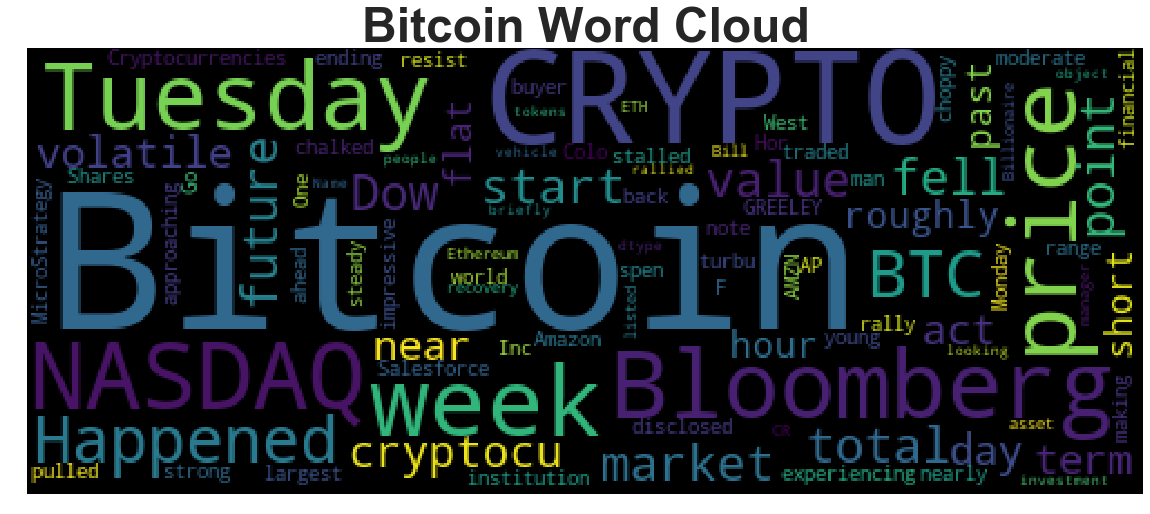

In [35]:
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

def wordcloud(tokens, title=""):
    df_cloud = WordCloud(width=500).generate(str(tokens))
    plt.imshow(df_cloud)
    plt.axis("off")
    fontdict = {"fontsize": 48, "fontweight" : "bold"}
    plt.title(title, fontdict=fontdict)
    plt.show()

# Generate the Bitcoin word cloud
wordcloud(btc_news_sent['tokens'], title="Bitcoin Word Cloud")

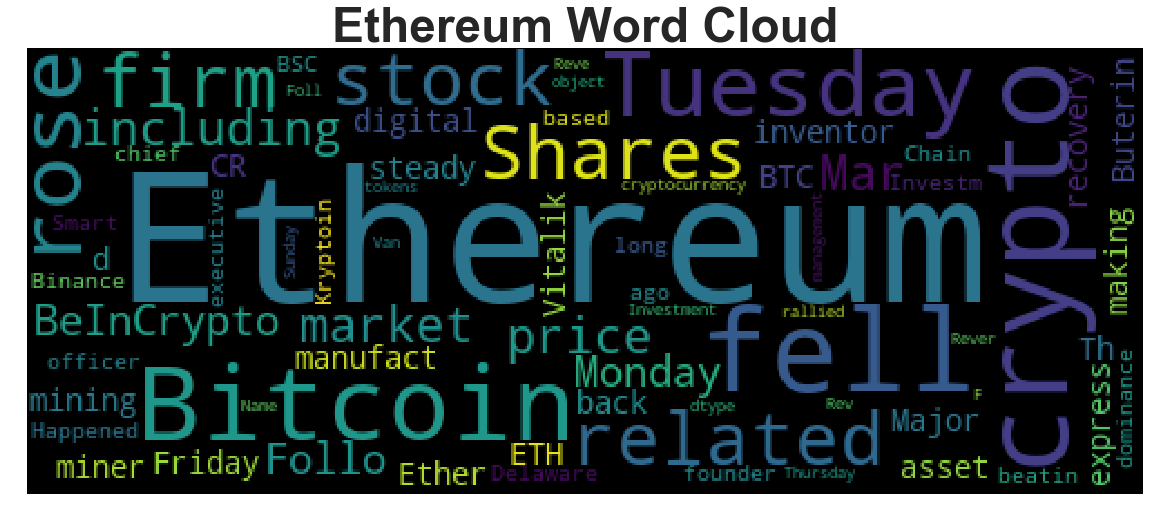

In [36]:
# Generate the Ethereum word cloud
wordcloud(eth_news_sent['tokens'], title="Ethereum Word Cloud")

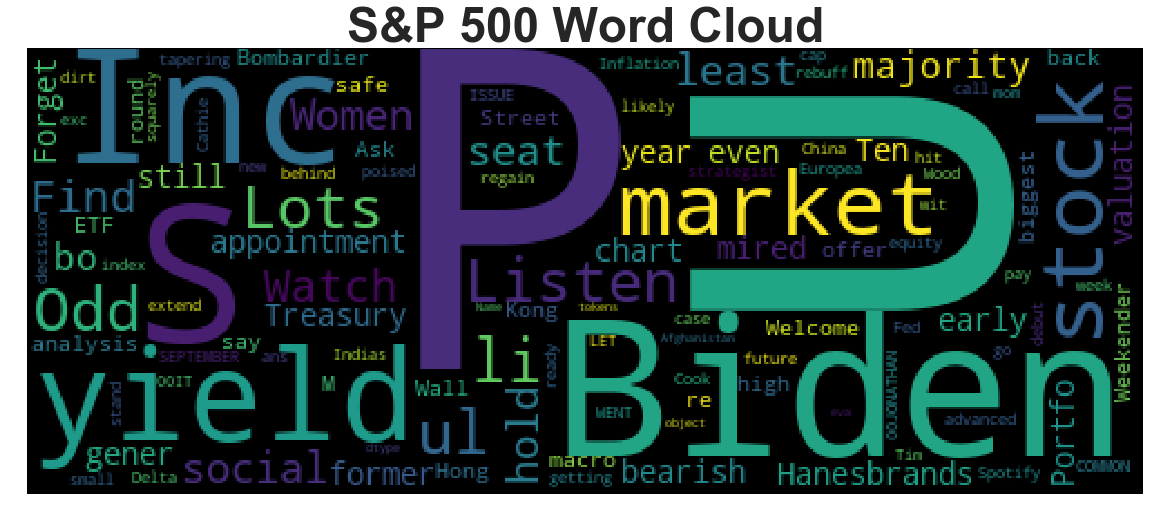

In [37]:
# Generate the S&P 500 word cloud
wordcloud(sp_news_sent['tokens'], title="S&P 500 Word Cloud")

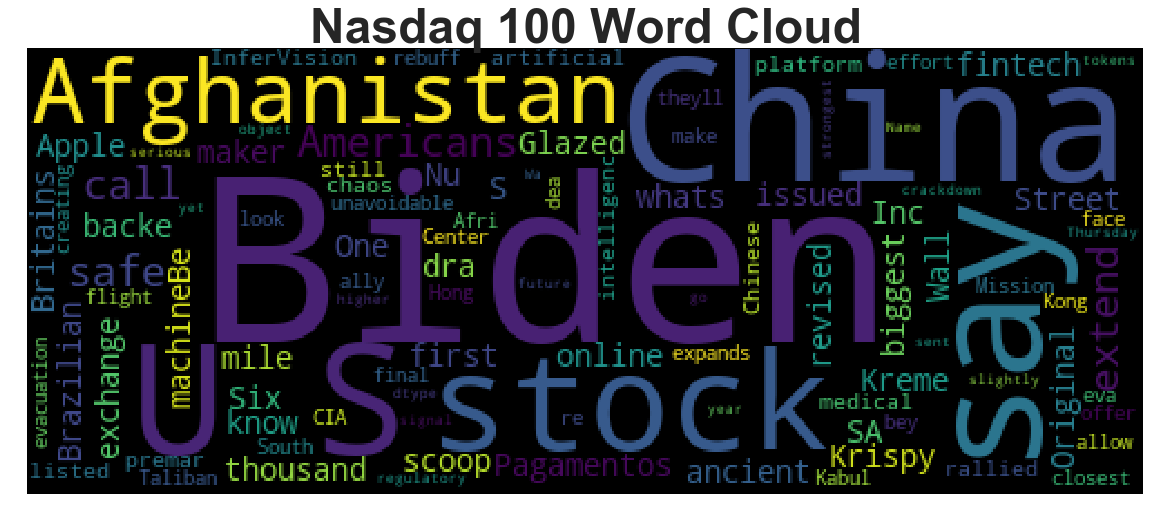

In [38]:
# Generate the Nasdaq 100 word cloud
wordcloud(qqq_news_sent['tokens'], title="Nasdaq 100 Word Cloud")

## Named Entity Recognition

In [39]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Concatenate all of the Bitcoin text together
btc_text = (btc_news_sent['text'].str.cat())
btc_text

'Dow futures fell more than 110 points to start the week, with investors concerned about potential slow growth in China as a sign of global economic weakness. Retail sales in China rose at an 8.5% cli… [+4373 chars](Bloomberg) -- The total market value of cryptocurrencies rose above $2 trillion again as Bitcoin continued to climb and the likes of Cardano, XRP and Dogecoin advanced as well.\r\nCryptos market value… [+1741 chars]It was a volatile day for bitcoin, as its near-term price actions suggest considerable price swings amid signs indicating bitcoin buyers will likely face stiff resistance around the 200-day simple mo… [+1596 chars]Bitcoin is roughly flat over the past 24 hours as short-term momentum fades. The past few days have been relatively quiet in the crypto market, which typically precedes periods of higher volatility. … [+8297 chars]Cryptocurrencies are ending the week on a strong note as bitcoin broke above $48,000 for the first time since May. The world’s largest crypto

In [40]:
# Run the NER processor on all of the text
btc_doc = nlp(btc_text)

# Add a title to the document
btc_doc.user_data["title"] = "Bitcoin Named Entity Recognition"

# Render the visualization
displacy.render(btc_doc, style='ent', jupyter=True)

In [41]:
# List all Entities
btc_ent = [ent.text for ent in btc_doc.ents if ent.label_ in ['GPE', 'ORG', 'PERSON', 'PRODUCT']]
btc_ent

['China',
 'China',
 '+4373 chars](Bloomberg',
 'Cardano, XRP and Dogecoin',
 'Cryptos',
 'chars]MicroStrategy Inc.',
 'MicroStrategy',
 'BlackRock',
 'the Federal Reserve’s',
 'Jackson Hole',
 'Amazon.com',
 'Salesforce.com',
 'NYSE',
 'CRM',
 'Nvidia',
 'NVDA',
 "Barron's",
 'Colo.',
 'AP',
 'Horace Greeley',
 'Colorado',
 'Ethereum',
 'Riot Blockchain Inc',
 'Ethereum',
 'Bill Miller']

In [42]:
# Concatenate all of the Ethereum text together
eth_text = (eth_news_sent['text'].str.cat())

# Run the NER processor on all of the text
eth_doc = nlp(eth_text)

# Add a title to the document
eth_doc.user_data["title"] = "Ethereum Named Entity Recognition"

# Render the visualization
displacy.render(eth_doc, style='ent', jupyter=True)

In [43]:
# List all Entities
eth_ent = [ent.text for ent in eth_doc.ents if ent.label_ in ['GPE', 'ORG', 'PERSON', 'PRODUCT']]
eth_ent

['Marathon Digital Holdings Inc',
 'Riot Blockchain Inc',
 'Coinbase Global Inc',
 '+991',
 'Ethereum',
 'London',
 'Marathon Digital Holdings Inc',
 'Riot Blockchain Inc',
 'Coinbase Global Inc',
 '+949 chars]Crypto',
 'Ethereum',
 'Vitalik Buterin',
 'Jack Dorsey',
 'Mark Zuckerberg',
 'Dorsey',
 'Ethereum',
 'Ethereum',
 'Delaware',
 'Kryptoin Investment Advisors',
 'Ethereum',
 'the U.S. Securities and Exchange Commission',
 'The Kryptoin Ethereum ETF Trust',
 'Binance Smart Chain',
 'BSC',
 'Ethereum',
 'Ethereum',
 'Ethereum',
 'Ethereum',
 'Ethereum',
 'Ethereum',
 'VanEck',
 'ETF',
 'the U.S. SEC',
 'Ethereum',
 'The United States Securities and Exchange Commission',
 'SEC',
 'Ethereum',
 'Ethereum',
 'Ethereum',
 'Ethereum',
 'Ethereum']

In [44]:
# Concatenate all of the S&P 500 text together
sp_text = (sp_news_sent['text'].str.cat())

# Run the NER processor on all of the text
sp_doc = nlp(sp_text)

# Add a title to the document
sp_doc.user_data["title"] = "S&P 500 Named Entity Recognition"

# Render the visualization
displacy.render(sp_doc, style='ent', jupyter=True)

In [45]:
# List all Entities
sp_ent = [ent.text for ent in sp_doc.ents if ent.label_ in ['GPE', 'ORG', 'PERSON', 'PRODUCT']]
sp_ent

['Hanesbrands Inc.',
 'Joia Johnson',
 'Regions Financial Corp.',
 'Banks',
 'Treasury',
 'Linda Duessel',
 'Federated Hermes',
 'Global Ratings',
 'Moodys Investors Service',
 'U.S.',
 'Hong Kong',
 'Evergrandes',
 '+287',
 'Bloomberg',
 'Nagaraj Shetti',
 'HDFC Securities',
 'chars]Tim Cook',
 'the Apple Inc.',
 'Apple Podcasts',
 'Joe Weisenthal\xa0',
 'Federal Reserve',
 'Wood',
 'Ark Investment Managements',
 'Fed',
 'China',
 '+200 chars]<ul><li>00:00JONATHAN',
 'TIMES',
 'RARE GOLD COINS\r\nBACK',
 'U.S.',
 'Afghanistan',
 'China',
 'Joe',
 'Afghanistan',
 'U.S.']

In [46]:
# Concatenate all of the Nasdaq 100 text together
qqq_text = (qqq_news_sent['text'].str.cat())

# Run the NER processor on all of the text
qqq_doc = nlp(qqq_text)

# Add a title to the document
qqq_doc.user_data["title"] = "Nasdaq 100 Named Entity Recognition"

# Render the visualization
displacy.render(qqq_doc, style='ent', jupyter=True)

In [47]:
# List all Entities
qqq_ent = [ent.text for ent in qqq_doc.ents if ent.label_ in ['GPE', 'ORG', 'PERSON', 'PRODUCT']]
qqq_ent

['Almaty',
 'T-Club',
 'Grisha and S',
 'Pagamentos SA',
 'Warren Buffetts \r\nBerkshire Hathaway Inc.',
 'Kreme Inc.',
 'Original Glazed',
 'Cairo',
 'North Africa',
 'Shanghais Nasdaq-style',
 'Apple',
 "Mark Gurman's",
 'Adtran Inc.',
 'U.S.',
 'ADVA Op',
 'Just Eat Takeaway',
 'U.S.',
 'JD.com Inc.',
 'Pinduoduo Inc.',
 'Hong Kong',
 'Hong Kong',
 'Afghanistan',
 'Chinas',
 'Afghanistan',
 'China',
 'Huarong',
 'Heres',
 'U.S.',
 'Kabul',
 'U.S.',
 'Xi Jinping',
 'Kabul',
 'Taliban',
 'Kabul',
 'China',
 'Singapore',
 'U.S.',
 'Kabul',
 'Singapore',
 'Afghanistan',
 'U.S.',
 'CIA',
 'China',
 'U.S.',
 'Hong Kong',
 'Evergrandes',
 'U.S.',
 'China',
 'U.S.',
 'U.S.',
 'The State Council',
 'Chinas']

# PRICE PREDICTOR MODEL

In [48]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [49]:
# Collect all asset data used into one list
assets = ['BTC-USD', 'ETH-USD', 'SPY',  'QQQ']

# Download each ticker data individually
for ticker in assets:
    data = yf.download(ticker, group_by="Ticker", period='max')
    data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True)
    data.columns = [ticker]
    data.to_csv(f'ticker_{ticker}.csv')  # ticker_AAPL.csv for example
    
sorted(assets)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['BTC-USD', 'ETH-USD', 'QQQ', 'SPY']

In [50]:
# Set the path to the files
p = Path('c:/Users/jorda/Desktop/Project2Code')

# Find the files
files = list(p.glob('ticker_*.csv'))

# Read the files into a dataframe
df_list = list()
for file in files:
    df_list.append(pd.read_csv(file))

# Combine dataframes
assetclosedata = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), df_list)#.fillna('void')
assetclosedata.reset_index(drop=True, inplace=True)
assetclosedata.set_index('Date', inplace=True)
assetclosedata.head()

BTC-USD  ETH-USD         QQQ         SPY
Date                                                   
2014-09-17  457.334015      NaN   99.529999  200.750000
2014-09-18  424.440002      NaN  100.279999  201.820007
2014-09-19  394.795990      NaN   99.980003  200.699997
2014-09-20  408.903992      NaN         NaN         NaN
2014-09-21  398.821014      NaN         NaN         NaN

In [51]:
# Get the closing prices of assets to be predicted
btcethclose = assetclosedata.copy()
btcethclose.drop(columns=['QQQ', 'SPY'], inplace = True)

btcclose = btcethclose.copy()
btcclose.drop(columns='ETH-USD', inplace = True)
btcclose.dropna(inplace=True)

ethclose = btcethclose.copy()
ethclose.drop(columns='BTC-USD', inplace = True)
ethclose.dropna(inplace=True)

spyqqqclose = assetclosedata[['SPY', 'QQQ']].copy()
spyqqqclose.dropna(subset=['SPY'], inplace=True)
spyclose = spyqqqclose.copy()
spyclose.drop(columns='QQQ', inplace = True)
spyclose.dropna(inplace=True)

qqqclose = spyqqqclose.copy()
qqqclose.drop(columns='SPY', inplace = True)
qqqclose.dropna(inplace=True)

In [52]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

## Bitcoin Price Predictor

In [53]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

feature_column = 0
target_column = 0
X, y = window_data(btcclose, window_size, feature_column, target_column)

In [54]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [55]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [56]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Build and Train the Long Term Short Term Memory (LSTM) Reccurent Neural Network (RNN)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
model = Sequential()
model.add(LSTM(
    units=30, return_sequences=True,
    input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dropout(0.2))
model.add(Dense(1))

In [58]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [60]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=50, verbose=1)

Epoch 1/10
36/36 [==============================] - 3s 8ms/step - loss: 0.0218
Epoch 2/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0369
Epoch 3/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 4/10
36/36 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 5/10
36/36 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 6/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 7/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 8/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 9/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 10/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0023


## Model Performance

In [61]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.003786264220252633

In [62]:
# Make some predictions
predicted = model.predict(X_test)

In [63]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [64]:
# Create a DataFrame of Real and Predicted values
btcpred = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = btcclose.index[-len(real_prices): ]) 
btcpred.head()

Real     Predicted
Date                                  
2019-08-05  10970.184570   9912.247070
2019-08-06  11805.653320   9970.146484
2019-08-07  11478.168945  10073.926758
2019-08-08  11941.968750  10261.642578
2019-08-09  11966.407227  10475.284180

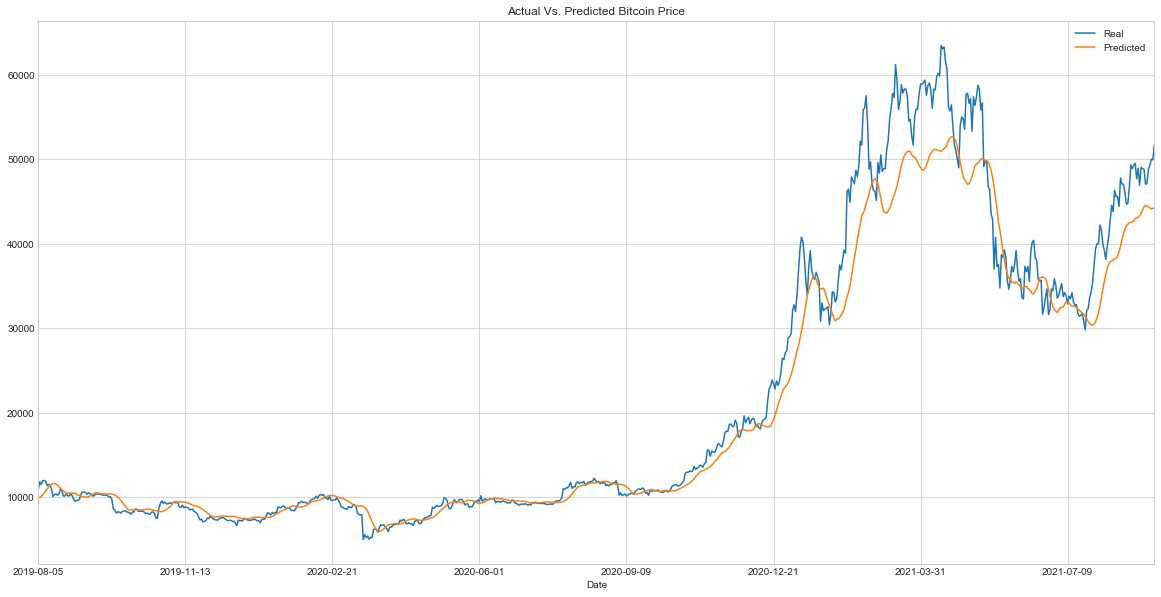

In [65]:
# Plot the real vs predicted values as a line chart
btcpred.plot(title="Actual Vs. Predicted Bitcoin Price")

## Ethereum Price Predictor

In [66]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

feature_column = 0
target_column = 0
X, y = window_data(ethclose, window_size, feature_column, target_column)

In [67]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [68]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [69]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Build and Train the Long Term Short Term Memory (LSTM) Reccurent Neural Network (RNN)

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
model = Sequential()
model.add(LSTM(
    units=30, return_sequences=True,
    input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dropout(0.2))
model.add(Dense(1))

In [71]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [72]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 30)            3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [73]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=50, verbose=1)

Epoch 1/10
31/31 [==============================] - 3s 9ms/step - loss: 0.0310
Epoch 2/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0263
Epoch 3/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 4/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 5/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 6/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 7/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 8/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 9/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 10/10
31/31 [==============================] - 0s 8ms/step - loss: 0.0022


## Model Performance

In [74]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.004115787334740162

In [75]:
# Make some predictions
predicted = model.predict(X_test)

In [76]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [77]:
# Create a DataFrame of Real and Predicted values
ethpred = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ethclose.index[-len(real_prices): ]) 
btcpred.head()

Real     Predicted
Date                                  
2019-08-05  10970.184570   9912.247070
2019-08-06  11805.653320   9970.146484
2019-08-07  11478.168945  10073.926758
2019-08-08  11941.968750  10261.642578
2019-08-09  11966.407227  10475.284180

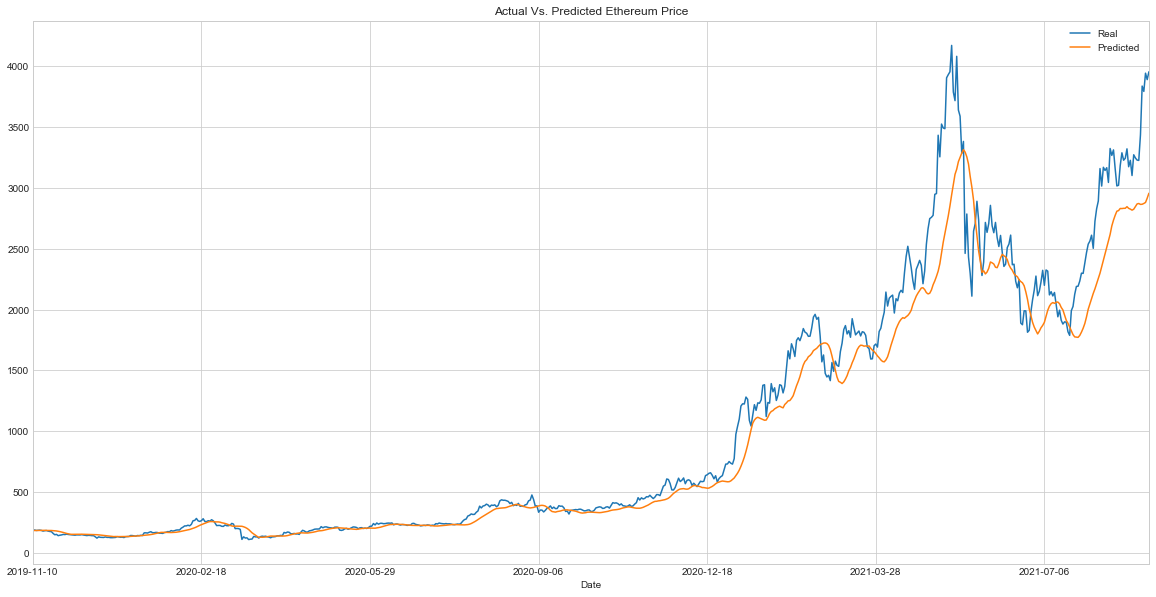

In [78]:
# Plot the real vs predicted values as a line chart
ethpred.plot(title="Actual Vs. Predicted Ethereum Price")